# Klasyfikacja raka mózgu - Hubert Jaremko

## Proces przetwarzania danych

### Opis zestawu danych
Cheng, Jun (2017): brain tumor dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.1512427.v5 

Zestaw danych zawiera 3064 obrazów z przewagą T1 pochodzących od 233 pacientów z trzema rodzajami nowotworów mózgu:
 - oponiak (*meningioma*, 708 obrazów), 
 - glejak (*glioma*, 1426 obrazów),
 - nowotwór przysadki (*pituitary tumor*, 930 obrazów).

Dane zostały zorganizowe w formacie matlaba (pliki `.mat`).
Każdy plik przechowuje strukture danych składającą się z następujących pól:
 - `cjdata.label`: `1` oznaczający oponiaka, `2` gelajka, `3` guz przysadki
 - `cjdata.PID`: ID pacjenta
 - `cjdata.image`: dane obrazu
 - `cjdata.tumorBorder`: wektor zawierajacy koordynaty punktów na granicy guza.
 - `cjdata.tumorMask`: obraz binarny, w którym jedynki oznaczają region guza

### Wczytanie obrazów formatu matlab

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [12]:
cancer_type = {1 : 'Oponiak', 2 : 'Glejak', 3 : 'Guz przysadki'}

In [13]:
def from_raw_pid(raw_pid):
    return ''.join([chr(c[0]) for c in raw_pid])

def from_raw_label(raw_label):
    return int(raw_label[0][0])

def from_raw(raw):
    return raw[0][0]

def from_raw_image(raw_image):
    return np.asarray(raw_image)

def read_raw_brain_data(index):
    import h5py
    brain_path = f'data/raw/{index}.mat'
    
    with h5py.File(brain_path, 'r') as file:
        image = from_raw_image(list(file['cjdata']['image']))
        label = from_raw_label(list(file['cjdata']['label']))
        return (image, label)
    return None

In [14]:
data_amount = 3064
start_i = 1
brains_data = [read_raw_brain_data(i) for i in range(start_i, start_i + data_amount)]

In [15]:
def plot_images(columns, rows, data):
    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns * rows + 1):
        img = data[i][0].T
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title(cancer_type[data[i][1]], fontsize=20)
        ax.set_yticks([])
        ax.set_xticks([])
        plt.imshow(img, cmap='gray')
    plt.show()

In [16]:
def filter_by_type(t, brains_data):
    return list(filter(lambda x: x[1] == t, brains_data))

In [17]:
type_1 = filter_by_type(1, brains_data)
type_2 = filter_by_type(2, brains_data)
type_3 = filter_by_type(3, brains_data)
print(f"Type 1 images: {len(type_1)}")
print(f"Type 2 images: {len(type_2)}")
print(f"Type 3 images: {len(type_3)}")

Type 1 images: 708
Type 2 images: 1426
Type 3 images: 930


### Próbka danych

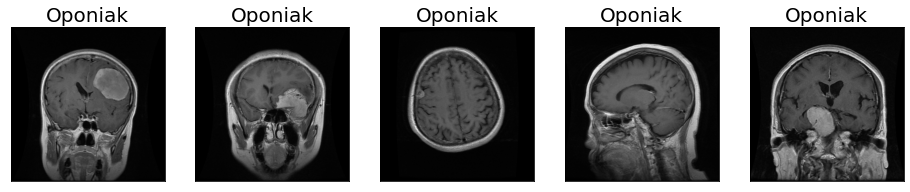

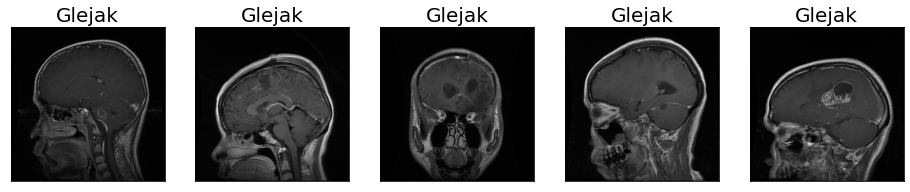

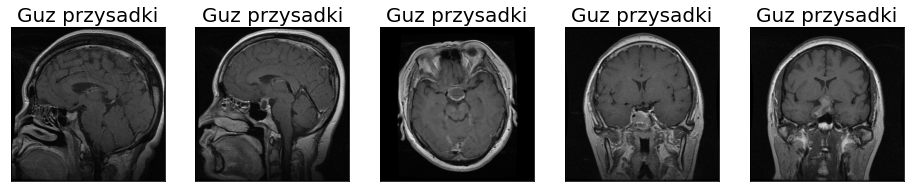

In [9]:
import random

random.shuffle(type_1)
random.shuffle(type_2)
random.shuffle(type_3)

plot_images(5, 1, type_1)
plot_images(5, 1, type_2)
plot_images(5, 1, type_3)

In [18]:
def plot_data_dist(type_1, type_2, type_3):
    df = pd.DataFrame(data={'Zestawy danych': [len(type_1), len(type_2), len(type_3)]}, index=[cancer_type[1], cancer_type[2], cancer_type[3]])
    df.plot(kind='bar', rot=0, legend=None)
    plt.title("Ilość zestawów danych ze wględu na rodzaj guza")
    plt.show()

### Rozkład klas

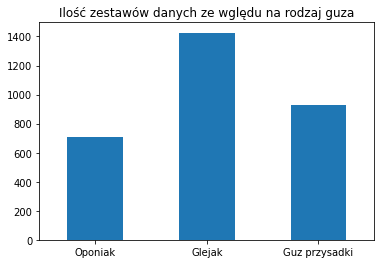

In [19]:
plot_data_dist(type_1, type_2, type_3)

### Zapisanie wszystkich obrazów

In [25]:
import matplotlib.image as mpimg
from random import sample
import random

In [ ]:
for i, img in enumerate(type_1):
    mpimg.imsave(f'data/extracted/1/{i}.jpg', img[0].T, cmap='gray')

for i, img in enumerate(type_2):
    mpimg.imsave(f'data/extracted/2/{i}.jpg', img[0].T, cmap='gray')

for i, img in enumerate(type_3):
    mpimg.imsave(f'data/extracted/3/{i}.jpg', img[0].T, cmap='gray')

### Wylosowanie mniejszej próbki ze względu na czas uczenia się

In [27]:
random.seed(123142)

for i, img in enumerate(sample(type_1, 200)):
    mpimg.imsave(f'data/sample/1/{i}.jpg', img[0].T, cmap='gray')

for i, img in enumerate(sample(type_2, 200)):
    mpimg.imsave(f'data/sample/2/{i}.jpg', img[0].T, cmap='gray')

for i, img in enumerate(sample(type_3, 200)):
    mpimg.imsave(f'data/sample/3/{i}.jpg', img[0].T, cmap='gray')

## Podzielnie na zbiór treningowy i testowy

In [28]:
import splitfolders

# data_dir = 'data/extracted'
data_dir = 'data/sample'

splitfolders.ratio(data_dir, output="data/", seed=123142, ratio=(0.8, 0.2))
# splitfolders.fixed(data_dir, output="data/", oversample=True, seed=123142, fixed=(800, 200, 100))
# splitfolders.fixed(data_dir, output="data/", oversample=True, seed=123142, fixed=(560, 140))

Copying files: 600 files [00:09, 62.49 files/s]


### Weryfikacja rozkładu

In [29]:
from os import walk
from PIL import Image

def read_brains(data, source, filenames, t):
    for filename in filenames:
        image = Image.open(f'data/{source}/{t}/{filename}').convert('L')
        img = np.array(image)
        data.append((img, t))

def plot_dir_distribution(directory):
    _, _, type_1_filenames = next(walk(f'data/{directory}/1/'))
    _, _, type_2_filenames = next(walk(f'data/{directory}/2/'))
    _, _, type_3_filenames = next(walk(f'data/{directory}/3/'))
    
    brains_data = []

    read_brains(brains_data, directory, type_1_filenames, 1)
    read_brains(brains_data, directory, type_2_filenames, 2)
    read_brains(brains_data, directory, type_3_filenames, 3)
    
    type_1 = filter_by_type(1, brains_data)
    type_2 = filter_by_type(2, brains_data)
    type_3 = filter_by_type(3, brains_data)
    plot_data_dist(type_1, type_2, type_3)

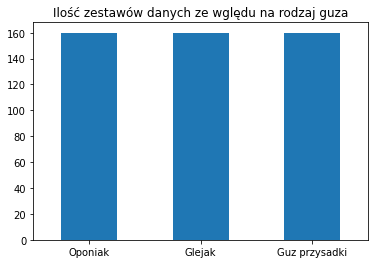

In [30]:
plot_dir_distribution('train')

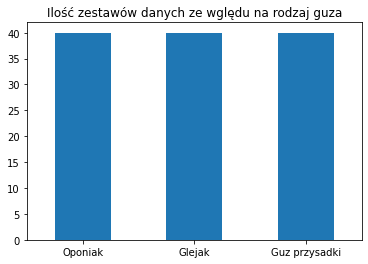

In [31]:
plot_dir_distribution('val')